## Adversarial examples

In [35]:
import PIL.Image as Image
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torchvision.models.inception import inception_v3
model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)


In [38]:
from torchvision import transforms
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

In [ ]:

!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

In [40]:
import requests
# class labels
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}


In [ ]:
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
print (img.shape)
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    ot = model(img)
    probs = torch.nn.functional.softmax(ot, dim=-1)
    
    probs = probs.detach().cpu().data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    print (top_ix)
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l][1]))
        


predict(img)


In [ ]:
modulelist = list(model.children())
print(len(modulelist))


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True,
                             dtype=torch.float32)
    
    print (type(input_var))
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        
        loss.backward()
        input_var.data = # YOUR CODE add gradient values to image data
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
#img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper_modified(img, ?, ?, ?)   # YOUR CODE
img_adv

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/hen.jpg -O sample_images/hen.jpg

In [ ]:
img1 = resize(plt.imread('sample_images/kitten.jpg'), (299, 299))
print (img1.shape)
plt.imshow(img1)
plt.show()
predict(img1)
#img_adv = dd_helper_modified(img, 4, 5, 0.5)   # YOUR CODE
#img_adv

In [ ]:
predict(np.array(img_adv))

## Deep Network Visulization

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg" />

**SHAP (SHapley Additive exPlanations)** is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).



Представим, что предсказание - результат командной игры и нужно понять, какой вклад в какое место результат внес каждый игрок(фича).

Вклад каждой фичи измеряется так называемой **Shapley value** - понятием из **cooperative game theory**, описывающим вклад фичи в предсказание.

Например, вы снимаете однушку в Москве и хотите создали модель, которая предскажет стоимость выбранного вами варианта. Для заданной квартиры модель предсказала цену 50.000 р. Свойства квартиры, по которой была предсказана цена: в пределах ТТК, есть кондиционер, с домашними лисицами нельзя, рядом находится парк. Нужно найти **Shapley value** свойства "с лисицами нельзя", при том, что средняя цена съема однушки 51.000.

**Shapley value** это среднее от возможных **marginal contributions**. Мы создаем все возможные наборы над множеством свойств, исключая интересующеек ("с лисицами нельзя"):



*   ни одного свойства
*   в пределах ТТК
*   кондей
*   рядом парк
*   в пределах ТТК, кондей
*   в пределах ТТК, рядом парк
*   кондей, рядом парк
*   в пределах ТТК, рядом парк, кондей


**Marginal contribution** = *model_predict*(в пределах ТТК, рядом парк, с лисицами нельзя) -  *model_predict*(в пределах ТТК, рядом парк)

**$$\text{Shapley value} =\frac{1}{S}\sum_{S}(\text{Marginal contribution})$$**
S - множество всех возможных наборов фичей


A prediction can be explained by assuming that each feature value of the instance is a “player” in a game where the prediction is the payout. Shapley values – a method from coalitional game theory – tells us how to fairly distribute the “payout” among the features.

In [ ]:
!pip3 install shap

In [4]:
import torch, torchvision
from torch import nn
from torchvision import transforms, models, datasets
import shap
import json
import numpy as np

# Explain an Intermediate Layers of Resnet50 on ImageNet

We use GradientExplainer model, which use expected gradients extention to estimate model's part input. In short, thay approximate SHAP values.

Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the convolution module from 2nd and 4th layers of the pretrained Resnet50 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to eyes and noses. The last layers have higher representations: they learn to recognize full objects, in different shapes and positions.
Let explain features from the second block of ResNet: "fine" features


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

Load proper model (**resnet50**) and data (**imagenet50**) from Shap wrapper

In [5]:
model = models.resnet50(pretrained=True).eval()

X,y = shap.datasets.imagenet50()

X /= 255

to_explain = X[[1, 41]]


# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)

with open(fname) as f:
    class_names = json.load(f)



## Layer 1

In [ ]:
e = # create GradientExplainer object for convolution layer from Resnet Layer1
shap_values,indexes = # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 2

In [ ]:
e = # create GradientExplainer object for convolution layer from Resnet Layer2
shap_values,indexes = # recieve shap_values

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
    
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 4

In [20]:
e = # create GradientExplainer object for convolution layer from Resnet Layer4
shap_values,indexes = # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

qu


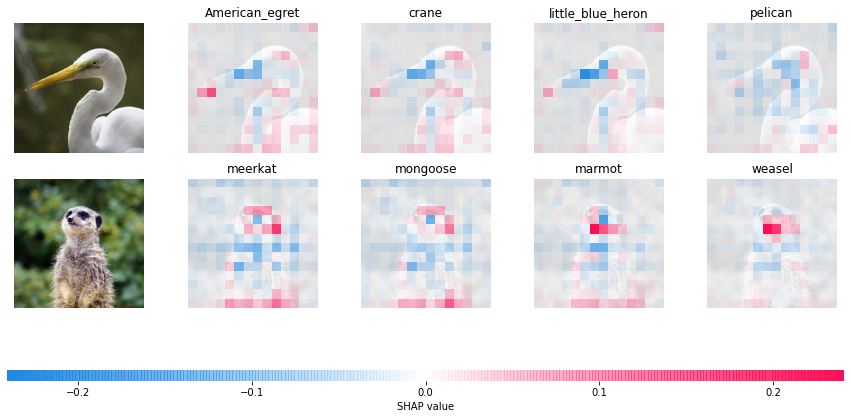

In [21]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Explain with local smoothing

Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

## Layer 2

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
e = # create GradientExplainer object for convolution layer from Resnet Layer2 with local smoothing
shap_values,indexes = # recieve shap_values

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

## Layer 4

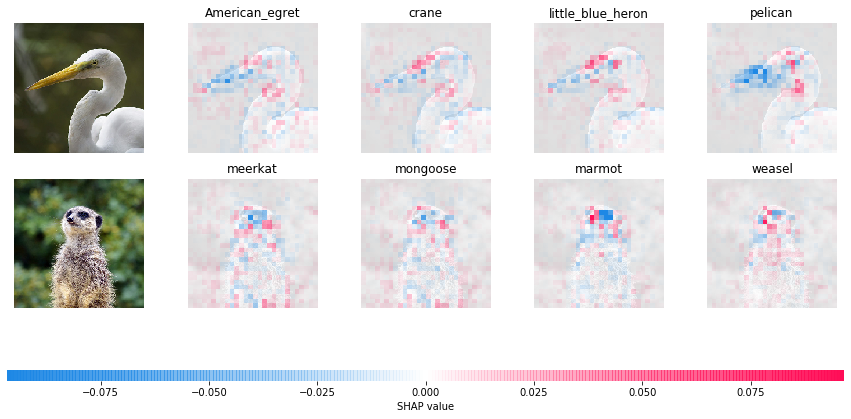

In [11]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
e = # create GradientExplainer object for convolution layer from Resnet Layer4 with local smoothing
shap_values,indexes = # recieve shap_values


# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

# Partition explainer

"Gamers" are not gradients but feature coalitions. Based on **Owen value** - an extension of Shapley value for cooperative games when a particular coalition structure or partition of the set of players is considered in addition.

In [72]:
model = models.resnet50(pretrained=True).eval()

X, y = shap.datasets.imagenet50()

In [73]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

axis=1

def normalize(images):
    #mean = np.mean(images, axis = (1, 2))
    #std = np.std(images, axis = (1, 2))
    if images.max() > 1:
        images /= 255
    images = (images - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(images.swapaxes(-1, 1).swapaxes(2, 3)).float()

def func(x):
    tmp = x.copy()
    tmp = normalize(tmp)
    return model(tmp).detach()

In [74]:
# create an masker
masker = #You code here

# create an explainer with model and image masker 
explainer = #You code here

In [ ]:
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]) 

In [ ]:
shap.image_plot(shap_values - 0.00009)